In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from funkwpap import sympy_to_gurobi, Firm, Country, Sector, Regulator, get_emission
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt

In [2]:
x, y = sp.symbols('x y')
# Create Sectors and Countries
Regulator3 = Regulator('EU', permit_price= 2, emission_cap= 100)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator3)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator3)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator3)
country1 = Country('DE', 1, regulator= Regulator3)
country2 = Country('FI', 0.5, regulator= Regulator3)
country3 = Country('GR', size= 0.1, regulator= Regulator3)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 0.1*sp.exp('x') + 100/y**2, 0, 0, 0, regulator= Regulator3)
firm2 = Firm('firm2', 1, 2, x*0, 5*x**3.2 + 40/y**2, 0, 0, 0, regulator= Regulator3)
firm3 = Firm('firm3', 1, 3, x*0, x**5.2 + 30/y**2, 0, 0, 0, regulator= Regulator3)
firm4 = Firm('firm4', 2, 1, x*0, x**3.3 + 20/y**2, 0, 0, 0, regulator= Regulator3)
firm5 = Firm('firm5', 2, 2, x*0, x**2.3 + 20/y**2, 0, 0, 0, regulator= Regulator3)
firm6 = Firm('firm6', 2, 3, x*0, x**3.2 + 15/y**2, 0, 0, 0, regulator= Regulator3)
firm7 = Firm('firm7', 3, 1, x*0, x**4.1 + 40/y**2, 0, 0, 0, regulator= Regulator3)
firm8 = Firm('firm8', 3, 2, x*0, x**5.1 + 50/y**2, 0, 0, 0, regulator= Regulator3)
firm9 = Firm('firm9', 3, 3, x*0, x**5 + 60/y**2, 0, 0, 0, regulator= Regulator3)


print(sector1.firms)  # List of firms in sector1
print(country1.firms)  # List of firms in country1
print(Regulator3.firm_registry)  # Dictionary of all firms

for firm in Regulator3.firm_registry.values():
    print(firm.name, firm.sector.name, firm.country.name)

[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0)]
[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=7, name='firm7', sector_id=3, country_id=1, actual_output=0, emission=0, profit=0)]
{1: Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), 2: Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), 3: Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0), 4: Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), 5: Firm(id=5, name='firm5', sector_id=2, country_id=2, actual_out

In [19]:
# Read a csv file that has the column names in the first row and some entries are lists of floats which are writeen inside double quotes to seperate those commas from the commans of the scv file. 
with open ('../data/generated/Permit_price_output_to_cap_v_0.csv', 'r') as f:
    df = pd.read_csv(f)
    for i in range(40,41):
        # print(df.iloc[i,0])
        Regulator3.emission_cap = df.iloc[i,0]
        Regulator3.permit_price = df.iloc[i,1]
        Outputs = df.iloc[i,2].replace('(','').replace(')','').split(',')
        Emissions = df.iloc[i,3].replace('(','').replace(')','').split(',')
        Profits = df.iloc[i,4].replace('(','').replace(')','').split(',')
        Sales = []
        Abatements = []
        Trades = []
        for firm in Regulator3.firm_registry.values():
            firm.actual_output = float(Outputs[firm.id-1])
            firm.emission = float(Emissions[firm.id-1])
            firm.profit = float(Profits[firm.id-1])
            Sales.append(firm.calculate_sales())
            Abatements.append(firm.calculate_abatement())
            Trades.append(firm.calculate_trading())

Abatements

[1.74904135789702e+20,
 74.8133653385974,
 38.1888732178058,
 137.092409877664,
 760.743031126457,
 143.773020835479,
 130.576497280733,
 42.5245241612148,
 82.3337015672608]

0     1.000019e+08
1     6.666682e+07
2     5.555572e+07
3     4.444462e+07
4     4.444438e+07
          ...     
64    4.547474e-01
65    4.547474e-01
66    4.547474e-01
67    4.547474e-01
68    4.547474e-01
Name: Permit Price, Length: 69, dtype: float64


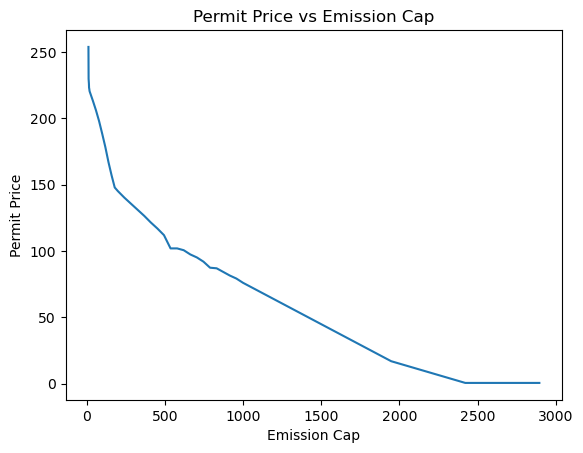

In [4]:
# Read a csv file that has the column names in the first row and some entries are lists of floats which are writeen inside double quotes to seperate those commas from the commans of the scv file. 
with open ('../data/generated/Permit_price_output_to_cap_v_0.csv', 'r') as f:
    df = pd.read_csv(f)
#print(df.head)
print(df['Permit Price'])
#print(df.columns)

# Create a list of the permit prices
permit_price = df['Permit Price'].to_list()
# Create a list of the Emission Cap 
emission_cap = df['Emission Cap'].to_list()

# Plot the permit price against the emission cap
plt.plot(emission_cap[11:55], permit_price[11:55])
plt.xlabel('Emission Cap')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Emission Cap')
plt.show()

   